In [1]:
from os import listdir
from os.path import isfile, join
import os
import pandas as pd
import numpy as np
import PIL
import PIL.Image, PIL.ExifTags
import datetime
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
from sqlalchemy import create_engine
import sqlalchemy as sqla
import cv2 as cv
import tensorflow as tf

## Setup

In [2]:
SQLITE_DB = '../data/interim/CAP_images.db'

In [3]:
engine = create_engine("sqlite:///{}".format(SQLITE_DB))
conn = engine.connect()

In [4]:
plt.rcParams.update({'font.size': 18, 'font.family':'serif'})

In [5]:
# Assumes that \\g44data1\g44data1_fema\Data_External\Imagery\CAP is mounted at /mnt/CAP_data
# change directory to your own mount location as necessary
data_dir_root = "/mnt/CAP_data/"
image_folder = "images/florence/"
data_dir = join(data_dir_root, image_folder)

In [6]:
docker_root = '/c/DockerMounts/'
saved_models_dir = join(docker_root,'tf_server/models')

In [12]:
files = [f for f in listdir(data_dir) if isfile(join(data_dir, f))]

In [7]:
with open(join(data_dir, 'analysis/file_list.txt'), 'r') as file_list:
    files = [l.rstrip() for l in file_list.readlines()]

In [26]:
files

['001_3fb56947-516b-4315-8347-716298444047.jpg',
 '002_fd2d53d0-ca31-42f1-a9a1-95c36b6a5b78.jpg',
 '003_b01a6d2b-6889-46f7-aa13-d8de6ae5a0a1.jpg',
 '004_17f80f52-0ac4-4af9-be41-b3a53ab3d2ac.jpg',
 '005_c5fc0a98-d5f1-416f-b0be-f37bcb7ef9c2.jpg',
 '006_8ef13688-b009-4b48-92a2-3e0c1c9434a3.jpg',
 '007_4acfb4bc-765f-4935-ab24-27c26fe0742a.jpg',
 '008_04245540-6d42-4ebe-b742-73f3ff2da8e8.jpg',
 '009_44bee59b-61b0-4235-a179-b58f5b698304.jpg',
 '010_de221a9d-0999-4d1a-b57a-9a5c9e453c07.jpg',
 '011_f922c48d-ad34-43c4-97ce-3ff83cf3e0ed.jpg',
 '012_12787d04-d939-4dfb-8801-f77431788e0d.jpg',
 '013_f1b02de9-534c-4259-aa13-ea1e5c71adeb.jpg',
 '014_48de48fa-2530-410e-8a51-e6f1f4cdc303.jpg',
 '015_91091592-cd31-429d-a347-be342875fd6a.jpg',
 '016_ef0d6639-fab9-421b-9c9e-3ea27830c6bd.jpg',
 '017_3f2ca8d8-b178-4c43-a465-8e41a56dec67.jpg',
 '018_8bbce05d-108c-4844-8080-705ce0b71fbb.jpg',
 '019_467844d3-ed4c-4b62-8345-ae505482dda5.jpg',
 '020_166c9c10-c0ce-4cc9-822a-8c684451bf0f.jpg',
 '021_c6757893-7b6d-

# Build dataframe of metadata

### Notes
- Data defaults to "None" if data is missing for a given feature

- Time zones are not included in exif data. They're technically in the exif spec now, but it seems like most manufactures haven't implemented, so there's no guarantee about whether the timestamps are all in local time.

In [145]:
from sqlalchemy.ext.automap import automap_base 
aBase = automap_base() 
aBase.prepare(engine, reflect=True)

In [146]:
aBase.classes.metadata

sqlalchemy.ext.automap.metadata

In [115]:
join(data_dir_root, image_folder, file)

'/mnt/CAP_data/images/florence/Watereet_f7066238-c48f-4d56-9aaa-3eb48a242c7b.jpg'

In [116]:
def get_metadata(root_dir, image_dir, file, columns):
    '''Returns a dictionary of metadata values corresponding to 'columns' argument from the exif data of
    file given by 'filename = join(root_dir, image_dir, file)', i.e. root_dir/image_dir/file
    Uses the path relative to root_dir as index, i.e. 'imagedir/file'
    Expands the 'GPSInfo' exiftag so it's on the same level as rest of exif tags
    DateTime entry is formatted as datetime object for convenience
    '''
    filename = join(root_dir, image_dir, file)
    meta_entry = {c:None for c in columns}
    meta_entry['Filename'] = join(image_dir, file)
    try:
        img = PIL.Image.open(filename)
        exif_data = img._getexif()
        exif = {PIL.ExifTags.TAGS[k]:v for k,v in exif_data.items() if k in PIL.ExifTags.TAGS}
    except:
        return meta_entry
    try:
        gps_exif = {PIL.ExifTags.GPSTAGS[k]:v for k,v in exif['GPSInfo'].items() if k in PIL.ExifTags.GPSTAGS}
    except:
        gps_exif = {}
    exif.update(gps_exif)
    
    meta_entry['FileSize'] = os.stat(filename).st_size
    for k,v in exif.items():
        if k in columns:
            meta_entry[k] = v
    meta_entry['DateTime'] = datetime.datetime.strptime(exif['DateTime'],'%Y:%m:%d %H:%M:%S')
    return meta_entry
    

In [74]:
def convert_GPS_coord(GPS_tuple):
    """ Converts the GPS coordinate given by exif into decimal coord
    GPS_Tuple = (
       (degreesNumerator, degreesDenominator), 
       (minutesNumerator, minutesDenominator), 
       (secondsNumerator, secondsDenominator)
       )
    """
    try:
        hr_tuple = GPS_tuple[0]
        degs = hr_tuple[0]/hr_tuple[1]
        min_tuple = GPS_tuple[1]
        mins = min_tuple[0]/min_tuple[1] 
        sec_tuple = GPS_tuple[2]
        secs = sec_tuple[0]/sec_tuple[1] 
        return degs + mins/60 + secs/3600
    except:
        return None

In [100]:
def divide_tuple(tup):
    try:
        quot = tup[0]/tup[1]
        return quot
    except:
        return None

In [76]:
# Name of the columns to include in the table
columns = ['Filename',
 'GPSVersionID',
 'GPSLatitudeRef',
 'GPSLatitude',
 'GPSLongitudeRef',
 'GPSLongitude',
 'GPSAltitudeRef',
 'GPSAltitude',
 'GPSSatellites',
 'FileSize',
 'ISOSpeedRatings',
 'DigitalZoomRatio',
 'ExposureTime',
 'ExifImageWidth',
 'ExifImageHeight',
 'DateTime']

In [118]:
meta_df = pd.DataFrame(columns=columns)
num_imgs = len(files)
for idx,file in enumerate(files):
    meta_entry = get_metadata(data_dir_root, image_folder, file, columns)
    meta_df = meta_df.append(meta_entry, ignore_index=True)
    if np.mod(idx,10)==0:
        print('Percentage:{0:2.1f}%'.format(100*(idx/num_imgs)),end='\r')
meta_df = meta_df.dropna(subset=['DateTime']) # drop images that don't have a timestamp
meta_df['GPSLatitude'] =meta_df['GPSLatitude'].apply(convert_GPS_coord)
meta_df['GPSLongitude'] =meta_df['GPSLongitude'].apply(convert_GPS_coord)
meta_df['GPSAltitude'] = meta_df['GPSAltitude'].apply(divide_tuple)
meta_df['DigitalZoomRatio'] =meta_df['DigitalZoomRatio'].apply(divide_tuple)
meta_df['ExposureTime'] = meta_df['ExposureTime'].apply(divide_tuple)
meta_df = meta_df.fillna(0) # fill out nans with 0

In [136]:
datatypes = {'Filename':sqla.String(),
 'GPSVersionID':sqla.String(),
 'GPSLatitudeRef':sqla.String(),
 'GPSLatitude':sqla.String(),
 'GPSLongitudeRef':sqla.String(),
 'GPSLongitude':sqla.String(),
 'GPSAltitudeRef':sqla.String(),
 'GPSAltitude':sqla.String(),
 'GPSSatellites':sqla.String(),
 'FileSize':sqla.Integer(),
 'ISOSpeedRatings':sqla.Integer(),
 'DigitalZoomRatio':sqla.String(),
 'ExposureTime':sqla.String(),
 'ExifImageWidth':sqla.Integer(),
 'ExifImageHeight':sqla.Integer(),
 'DateTime':sqla.DateTime()}
meta_df.to_sql('img_metadata', con=engine, if_exists='replace', dtype=datatypes)

In [113]:
conn.close()

# Plotting Metadata distributions

## Dates, Times

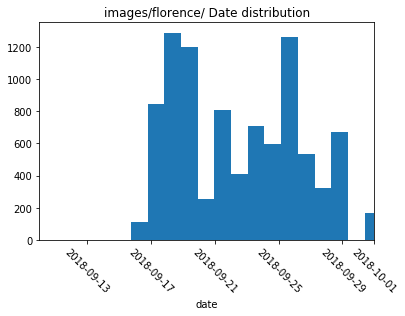

In [21]:
# Date distribution
plt.hist( pd.to_datetime(meta_df['DateTime']), bins=365)
plt.xlabel('date')
plt.title('{} Date distribution'.format(image_folder))
plt.xlim([datetime.datetime.strptime('2018-09-10','%Y-%m-%d'),
          datetime.datetime.strptime('2018-10-01','%Y-%m-%d')])
plt.xticks(rotation=-45)
plt.show()

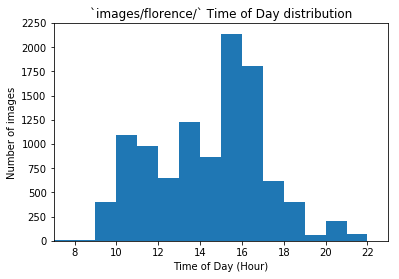

In [19]:
# Time of day (hourly)
plt.hist(pd.to_datetime(meta_df['DateTime']).dt.hour,bins=range(23))
plt.xlim([7,23])
plt.xlabel('Time of Day (Hour)')
plt.ylabel('Number of images')
plt.title('{} Time of Day distribution'.format(image_folder))
plt.show()

/home/jeffliu/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<Figure size 432x288 with 0 Axes>

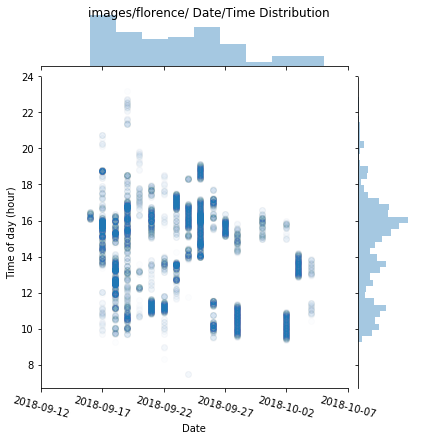

In [20]:
# Date, time of day
f = plt.figure()
time_of_day = pd.to_datetime(meta_df['DateTime']).dt.hour\
              + pd.to_datetime(meta_df['DateTime']).dt.minute/60
year = int(np.median(pd.to_datetime(meta_df['DateTime']).dt.year))
jplot = sns.jointplot(x=pd.to_datetime(meta_df['DateTime']).dt.dayofyear, 
                   y=time_of_day,
                  alpha=0.01, xlim=[255,280], )
jplot.set_axis_labels('Date', 'Time of day (hour)')
jplot.ax_joint.get_xaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: 
                                    datetime.datetime.strptime('{:d}'.format(int(x)),'%j')\
                                    .strftime('{:d}-%m-%d'.format(year))))
jplot.ax_joint.tick_params(axis='x', rotation=-15)
jplot.fig.suptitle('{} Date/Time Distribution'.format(image_folder))
plt.show()

## Image Resolution and filesize

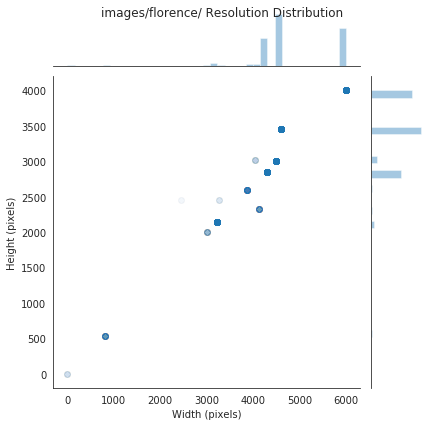

In [22]:
# Image Resolutions
with sns.axes_style('white'):
    ax = sns.jointplot(x=meta_df['ExifImageWidth'], y=meta_df['ExifImageHeight'], alpha=0.01)
    ax.set_axis_labels('Width (pixels)', 'Height (pixels)')
    ax.fig.suptitle('{} Resolution Distribution'.format(image_folder))

In [ ]:
#File Size
fig = plt.figure()
ax = plt.subplot(1,1,1)
ax.hist(meta_df['Filesize']/1000000) #scale to MB
ax.set_xlabel('size (MB)')
ax.set_title('File Size Distribution')

# GPS

# Edge Detection and Segmentation

In [336]:
def get_edges(img):
    lowres_img = img
    # Blur for further lowpass
    lowres_img = cv.GaussianBlur(lowres_img,(5,5),0)
    # bilat_filt for further noise reduction w/ edge preservation
    lowres_img = cv.bilateralFilter(lowres_img,9,75,75)
    # Compute edges
    edges = cv.Canny(lowres_img,50,200,apertureSize=5, L2gradient=True)
    return edges

def get_segmentation(img, thresh):
    # Try segmentation
    kernel = np.ones((5,5), np.uint8)
    opening = cv.morphologyEx(thresh,cv.MORPH_OPEN, kernel, iterations = 5)
    sure_fg = cv.dilate(opening, kernel, iterations=3)
    dist_transform = cv.distanceTransform(opening,cv.DIST_L2,5)
    ret, sure_bg = cv.threshold(dist_transform,0.5*dist_transform.max(),255,0)
    sure_bg = np.uint8(sure_bg)
    unknown = cv.subtract(sure_bg, sure_fg)
    # Marker labelling
    ret, markers = cv.connectedComponents(sure_fg)
    # Add one to all labels so that sure background is not 0, but 1
    markers = markers+1
    # Now, mark the region of unknown with zero
    markers[unknown==255] = 0
    # apply watershed
    markers = cv.watershed(img, markers)
    return markers

/mnt/CAP_data/images/florence/DSC_7020_d1928512-fd23-46f4-8344-8c41ce39a264.jpg


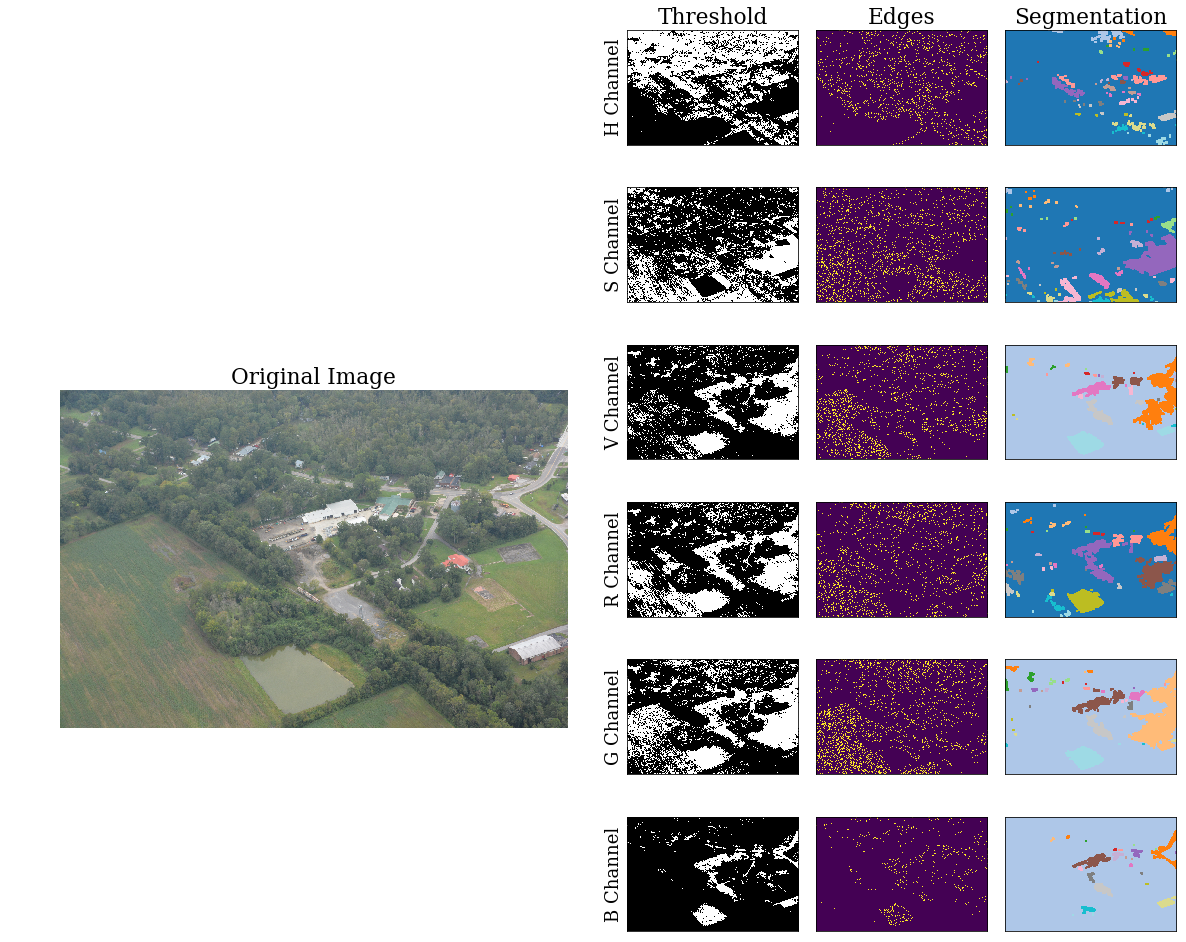

In [343]:

test_f = data_dir+files[5590]
print(test_f)
# Get raw image
raw_img = cv.imread(test_f, -1)
# Convert to lower resolution for analysis speedup
lowres_dim = 1800
img_shape = img.shape
img = cv.resize(raw_img,(int((img_shape[1]/img_shape[0])*lowres_dim), lowres_dim ))
# Convert to RGB from BGR (cv convention vs. plt convention)
RGB_img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
gray_img = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
HSV_img = cv.cvtColor(img, cv.COLOR_BGR2HSV)

# Threshold
ret, gray_thresh = cv.threshold(gray_img, 0,255, cv.THRESH_BINARY+cv.THRESH_OTSU)
# # HSV_thresh
# HSV_selector = 0
# ret, HSV_thresh = cv.threshold(HSV_img[:,:,HSV_selector], 0,255, cv.THRESH_BINARY+cv.THRESH_OTSU)
# thresh = HSV_thresh
# # RGB_thresh
# RGB_selector = 2
# ret, RGB_thresh = cv.threshold(RGB_img[:,:,RGB_selector], 0,255, cv.THRESH_BINARY+cv.THRESH_OTSU)
# thresh = RGB_thresh

thresh_array = np.concatenate((HSV_img, RGB_img), axis=2)

channels = {'H':0,'S':1,'V':2,'R':3,'G':4,'B':5}

# Plotting
fig = plt.figure(figsize=(20,20))
gs0 = gridspec.GridSpec(1,2)
gs = gridspec.GridSpec(7,6)
plt.subplot(gs0[0])
plt.axis('off')
plt.imshow(RGB_img)
plt.title('Original Image')
for channel, idx in channels.items():
    plt.subplot(gs[3+6*idx])
    plt.tick_params(axis='both', which='both', bottom=False, top=False, 
                    labelbottom=False, right=False, left=False, labelleft=False)
    ret, thresh = cv.threshold(thresh_array[:,:,idx], 0,255, cv.THRESH_BINARY+cv.THRESH_OTSU)
    plt.imshow(thresh, cmap='gray')
    if idx==0:
        plt.title('Threshold'.format(channel))
    plt.ylabel('{} Channel'.format(channel))
    plt.subplot(gs[4+6*idx])
    plt.tick_params(axis='both', which='both', bottom=False, top=False, 
                    labelbottom=False, right=False, left=False, labelleft=False)
    edges = get_edges(thresh)
    plt.imshow(edges)
    if idx==0:
        plt.title('Edges')
    plt.subplot(gs[5+6*idx])
    markers = get_segmentation(RGB_img, thresh)
    plt.imshow(markers, cmap='tab20'.format(channel))
    plt.tick_params(axis='both', which='both', bottom=False, top=False, 
                    labelbottom=False, right=False, left=False, labelleft=False)
    # plt.imshow(markers, cmap=sns.cubehelix_palette(n_colors=10, rot=1, as_cmap=True))
    if idx==0:
        plt.title('Segmentation')
gs.update(wspace=0.1, hspace=0.1)
plt.show()


In [293]:
for channel, idx in channels.items():
    print(idx)

1
2
3
4
5
6


In [267]:
contours.shape

(1, 58183, 4)

In [13]:
cv2.cuda

NameError: name 'cv2' is not defined

# Semantic Analysis

In [8]:
import grpc
from tensorflow_serving.apis import predict_pb2
from tensorflow_serving.apis import prediction_service_pb2_grpc
from tensorflow import keras
import requests
import sys
import base64
import logging
logging.basicConfig()
logging.getLogger().setLevel(logging.ERROR)

In [1]:
def get_imagenet_class_names():
    class_dict = {0:'null'}
    with open('../data/raw/imagenet_synset.txt', 'r') as class_f:
        class_list = [line.rstrip() for line in class_f]
        for idx, name in enumerate(class_list, 1):
            class_dict[idx] = name
    return class_dict

def get_places_class_names():
    class_dict = {}
    with open('../data/raw/places_categories.txt', 'r') as class_f:
        class_list = [line.rstrip() for line in class_f]
        for idx, name in enumerate(class_list):
            class_dict[idx] = name
    return class_dict
class_dict_imgnet = get_imagenet_class_names()
class_dict_places = get_places_class_names()

In [10]:
def get_weights(f_path, model_name):
    with open(f_path, 'rb') as f:
        data = f.read()

    if model_name == 'resnet_v2_CPU_jpg':
        channel = grpc.insecure_channel('localhost:8500')
        stub = prediction_service_pb2_grpc.PredictionServiceStub(channel)
    #     construct and send request
        request = predict_pb2.PredictRequest()
        request.model_spec.name = model_name
        request.model_spec.signature_name = 'serving_default'
        request.inputs['image_bytes'].CopyFrom(
            tf.make_tensor_proto(data, shape=[1]))
        result = stub.Predict(request, 10)  # 10 secs timeout
        weights = np.array(result.outputs['probabilities'].float_val)
    elif model_name == 'resnet152_places365':
        img = keras.preprocessing.image.img_to_array(keras.preprocessing.image.load_img(f_path, target_size=(224, 224)))/255
#         print(img)
        payload={"instances":[{'input_image':img.tolist()}]}
        result = requests.post('http://localhost:8501/v1/models/resnet152_places365:predict', json=payload,
                              timeout=10)
        result.raise_for_status()
#         print(result.json())
        weights=result.json()['predictions'][0]  
    return weights
    
def get_top_n(weights, n_top, class_dict):
    """
    Gets the human-readable names of the n_top most likely labels
    """
    top_idxes = np.argpartition(weights,-n_top)[-n_top:] # partition top five weights
    top_idxes = top_idxes[np.argsort(weights[top_idxes], )][::-1] # sort the top five weights
    top_weights = weights[top_idxes]
    return [class_dict[idx] for idx in top_idxes]
    

In [11]:
imgnet_columns = list(class_dict_imgnet.values())
places_labels = list(class_dict_places.values())
label_columns = imgnet_columns + places_labels
label_columns.insert(0, 'img_filename')
label_df = pd.DataFrame(columns=label_columns )
imgnet_model = 'resnet_v2_CPU_jpg'
# imgnet_sig = 'serving_default'
places_model = 'resnet152_places365'
# places_sig = 'serving_default'
for idx, filename in enumerate(files):
    f_path = join(data_dir, filename)
    try:
        imgnet_weights = get_weights(f_path, imgnet_model)
#         print({class_dict_imgnet[idx]:w for idx, w in enumerate(imgnet_weights)})
        places_weights = get_weights(f_path, places_model)
#         print({class_dict_places[idx]:w for idx, w in enumerate(places_weights)})
    except:
        pass
        weights = np.zeros(1001,)
    entry = {}
    for idx, w in enumerate(imgnet_weights):
        entry[class_dict_imgnet[idx]] = w
    for idx, w in enumerate(places_weights):
        entry[class_dict_places[idx]] = w
    entry['img_filename'] = join(image_folder, filename)
#     print(entry)
    label_df = label_df.append(entry, ignore_index=True)
    if np.mod(idx, 100)==0:
        print('Percentage labels processed:{0:2.1f}%'.format(100*((idx+1)/num_imgs)),end='\r')


In [12]:
label_df = label_df.set_index('img_filename')
label_df.to_sql('img_labels', con=engine, if_exists='replace')

In [2]:
for label in class_dict_places.values():
    print(label)

airfield
airplane_cabin
airport_terminal
alcove
alley
amphitheater
amusement_arcade
amusement_park
apartment_building/outdoor
aquarium
aqueduct
arcade
arch
archaelogical_excavation
archive
arena/hockey
arena/performance
arena/rodeo
army_base
art_gallery
art_school
art_studio
artists_loft
assembly_line
athletic_field/outdoor
atrium/public
attic
auditorium
auto_factory
auto_showroom
badlands
bakery/shop
balcony/exterior
balcony/interior
ball_pit
ballroom
bamboo_forest
bank_vault
banquet_hall
bar
barn
barndoor
baseball_field
basement
basketball_court/indoor
bathroom
bazaar/indoor
bazaar/outdoor
beach
beach_house
beauty_salon
bedchamber
bedroom
beer_garden
beer_hall
berth
biology_laboratory
boardwalk
boat_deck
boathouse
bookstore
booth/indoor
botanical_garden
bow_window/indoor
bowling_alley
boxing_ring
bridge
building_facade
bullring
burial_chamber
bus_interior
bus_station/indoor
butchers_shop
butte
cabin/outdoor
cafeteria
campsite
campus
canal/natural
canal/urban
candy_store
canyon
car_in

In [202]:
print([l for l in (label_df > 0.1).sum()])

['null', 'tench, Tinca tinca', 'goldfish, Carassius auratus', 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias', 'tiger shark, Galeocerdo cuvieri', 'hammerhead, hammerhead shark', 'electric ray, crampfish, numbfish, torpedo', 'stingray', 'cock', 'hen', 'ostrich, Struthio camelus', 'brambling, Fringilla montifringilla', 'goldfinch, Carduelis carduelis', 'house finch, linnet, Carpodacus mexicanus', 'junco, snowbird', 'indigo bunting, indigo finch, indigo bird, Passerina cyanea', 'robin, American robin, Turdus migratorius', 'bulbul', 'jay', 'magpie', 'chickadee', 'water ouzel, dipper', 'kite', 'bald eagle, American eagle, Haliaeetus leucocephalus', 'vulture', 'great grey owl, great gray owl, Strix nebulosa', 'European fire salamander, Salamandra salamandra', 'common newt, Triturus vulgaris', 'eft', 'spotted salamander, Ambystoma maculatum', 'axolotl, mud puppy, Ambystoma mexicanum', 'bullfrog, Rana catesbeiana', 'tree frog, tree-frog', 'tailed frog, bel

In [9]:
sess = tf.InteractiveSession()

# TF conversion

In [111]:
sess.close()
sess = tf.InteractiveSession()

/home/jeffliu/miniconda3/envs/image-analysis/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [112]:
loaded_k_model = keras.models.load_model('/c/DockerMounts/tf_server/models/keras_resnet152_places365.h5', compile=True)

In [115]:
keras.backend.set_learning_phase(0) # Ignore dropout at inference
loaded_k_model = keras.models.load_model('/c/DockerMounts/tf_server/models/keras_resnet152_places365.h5')
with keras.backend.get_session() as sess2:
    tf.saved_model.simple_save(sess2, '/c/DockerMounts/tf_server/models/resnet152_places365/',
                              inputs={'input_image': loaded_k_model.input},
                              outputs={t.name: t for t in loaded_k_model.outputs})

AttributeError: __enter__

In [114]:
sess.close()

In [21]:
print(keras.__version__)

2.1.6-tf


# Misc Reference

In [ ]:
PIL.ExifTags.TAGS

In [ ]:
PIL.ExifTags.GPSTAGS

In [ ]:
files

In [20]:
tf.saved_model.tag_constants.TRAINING

'train'